# **Búsqueda Informada (Fundamento de los sistemas operativos)**

---

Este proyecto ha sido desarrollado por Helen González Báez, Cristian Tomás Vega Appelqvist y Alejandro José Martel Torres. Para el desarrollo de los scripts nos hemos apoyado en los fundamentos explicados en clase, los *Jupyter Notebooks* de prácticas y la ayuda de Gemini en el planteamiento de algunas decisiones.


Hemos añadido al código base de la práctica el cálculo de los nodos visitados y generados, así como el coste total de la ruta. Además, dos estrategias: ramificacion y acotación, ramificacion y acotación con subesimación y fuerza bruta, como opcional para las comparaciones, para las cuales hemos implementado en utils.py la clase PriorityQueue y hemos creado las funciones necesarias para aplicar dichas estrategias.
Por último también hemos modificado el archivo run.py para mostrar los datos obtenidos en su totalidad.

run.py

In [ ]:
# run.py
import search
import time

# DEFINICIÓN DE LAS HERRAMIENTAS

def bfs_instrumented(problem): # problem: P_salida - P_meta - mapa
    return search.instrumented_graph_search(problem, search.FIFOQueue())


def dfs_instrumented(problem):
    return search.instrumented_graph_search(problem, search.Stack())


def bnb_instrumented(problem):
    return search.branch_and_bound_graph_search(problem)


def bnb_subestimation_instrumented(problem):
    return search.branch_and_bound_subestimation_graph_search(problem)

def brute_force_instrumented(problem):
    return search.brute_force_search(problem, search.FIFOQueue())


strategies = [
    ("Amplitud", bfs_instrumented),
    ("Profundidad", dfs_instrumented),
    ("Ramificación y Acotación", bnb_instrumented),
    ("R. y A. con Subestimación", bnb_subestimation_instrumented),
    ("Fuerza Bruta (Sin Memoria)", brute_force_instrumented)
]

# ---------------------------------------------------------------------
# 2. Casos de Prueba
# ---------------------------------------------------------------------
test_cases = [
    {"id": 1, "start": 'A', "goal": 'B', "label": "Arad -> Bucharest"},
    {"id": 2, "start": 'O', "goal": 'E', "label": "Oradea -> Eforie"},
    {"id": 3, "start": 'G', "goal": 'Z', "label": "Giurgiu -> Zerind"},
    {"id": 4, "start": 'N', "goal": 'D', "label": "Neamt -> Dobreta"},
    {"id": 5, "start": 'M', "goal": 'F', "label": "Mehadia -> Fagaras"}
]

# ---------------------------------------------------------------------
# 3. Ejecución con Medición de Tiempo (Alta Precisión)
# ---------------------------------------------------------------------

if __name__ == "__main__":
    # Ajustamos el ancho de la columna TIEMPO para los nuevos decimales
    header = f"{'CASO':<20} | {'ESTRATEGIA':<25} | {'GEN':<5} | {'VIS':<5} | {'COST':<5} | {'TIEMPO (s)':<12} | {'RUTA'}"
    print(header)
    print("-" * len(header))

    for case in test_cases:
        problem = search.GPSProblem(case['start'], case['goal'], search.romania)

        print(f"\n--- ID {case['id']}: {case['label']} ---")

        for name, strategy in strategies:
            try:
                # 1. Tomamos el tiempo inicial con alta precisión
                # perf_counter usa el reloj del procesador, ideal para tiempos cortos
                start_time = time.perf_counter()

                # 2. Ejecutamos la búsqueda
                node, generated, visited = strategy(problem)

                # 3. Tomamos el tiempo final
                end_time = time.perf_counter()

                # 4. Calculamos la diferencia
                elapsed_time = end_time - start_time

                if node:
                    cost = node.path_cost
                    path_nodes = node.path()
                    path_str = str([n.state for n in path_nodes])
                else:
                    cost = "N/A"
                    path_str = "SIN SOLUCIÓN"
                    generated = 0
                    visited = 0

                # Formateamos el tiempo con 8 decimales para ver diferencias pequeñas
                # Ejemplo: 0.00012345
                time_str = f"{elapsed_time:.8f}"

                print(f"{name:<25} | {generated:<5} | {visited:<5} | {cost:<5} | {time_str:<12} | {path_str}")

            except Exception as e:
                print(f"{name:<25} | ERROR: {e}")

    print("\n" + "-" * len(header))

search.py

In [ ]:
"""Search (Chapters 3-4)

The way to use this code is to subclass Problem to create a class of problems,
then create problem instances and solve them with calls to the various search
functions."""


from utils import *


# ______________________________________________________________________________

# ______________________________________________________________________________
# EXTENSIÓN PARA EL PROYECTO (Parte 1, 2 y 3)
# ______________________________________________________________________________



# 1. PriorityQueue lo hace todo (utils.py) añadido por nst

# 2. Motor de Búsqueda Instrumentado (Parte 3)
# Esta función es análoga a graph_search pero cuenta nodos generados y visitados.
def brute_force_search(problem, fringe):
    """
    Búsqueda por Fuerza Bruta: Explora TODO sin recordar
    por dónde ha pasado (sin lista 'closed').
    """
    fringe.append(Node(problem.initial))
    generated_nodes = 1
    visited_nodes = 0

    while fringe:
        node = fringe.pop()
        visited_nodes += 1

        if problem.goal_test(node.state):
            return node, generated_nodes, visited_nodes

        # ¡Aquí está la diferencia! No preguntamos si ya visitamos la ciudad.
        # Simplemente expandimos todo lo que vemos.
        successors = node.expand(problem)
        generated_nodes += len(successors)
        fringe.extend(successors)

    return None, generated_nodes, visited_nodes

def instrumented_graph_search(problem, fringe):
    """
    Realiza una búsqueda en grafo devolviendo estadísticas.
    Retorna: (nodo_solución, nodos_generados, nodos_visitados)
    """
    visitados = {}

    # Nodo inicial
    start_node = Node(problem.initial)
    fringe.append(start_node)

    generated_nodes = 1
    visited_nodes = 0

    while fringe:
        node = fringe.pop()
        visited_nodes += 1

        if problem.goal_test(node.state): # Observa si ya llegó al destino
            return node, generated_nodes, visited_nodes

        if node.state not in visitados:
            visitados[node.state] = True

            # Expandir sucesores
            successors = node.expand(problem)
            generated_nodes += len(successors) # Sumamos los hijos creados

            fringe.extend(successors)

    return None, generated_nodes, visited_nodes

# 3. Estrategias de Búsqueda (Parte 1 y 2)

def branch_and_bound_graph_search(problem):
    """
    Parte 1: Ramificación y Acotación (Coste Uniforme).
    Estrategia: Explorar el nodo con menor g(n) (path_cost).
    """
    return instrumented_graph_search(problem, PriorityQueue(f=lambda n: n.path_cost))

def branch_and_bound_subestimation_graph_search(problem):
    """
    Parte 2: Ramificación y Acotación con Subestimación (A*).
    Estrategia: Explorar el nodo con menor f(n) = g(n) + h(n).
    """
    # La heurística h(n) ya la provee la clase GPSProblem usando distancia euclídea
    return instrumented_graph_search(problem, PriorityQueue(f=lambda n: n.path_cost + problem.h(n)))


class Problem:
    """The abstract class for a formal problem.  You should subclass this and
    implement the method successor, and possibly __init__, goal_test, and
    path_cost. Then you will create instances of your subclass and solve them
    with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal.  Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def successor(self, state):
        """Given a state, return a sequence of (action, state) pairs reachable
        from this state. If there are many successors, consider an iterator
        that yields the successors one at a time, rather than building them
        all at once. Iterators will work fine within the framework."""
        abstract

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal, as specified in the constructor. Implement this
        method if checking against a single self.goal is not enough."""
        return state == self.goal

    def path_cost(self, c, state1, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2.  If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self):
        """For optimization problems, each state has a value.  Hill-climbing
        and related algorithms try to maximize this value."""
        abstract


# ______________________________________________________________________________

class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state.  Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node.  Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        update(self, state=state, parent=parent, action=action,
               path_cost=path_cost, depth=0)
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node %s>" % (self.state,)

    def path(self):
        """Create a list of nodes from the root to this node."""
        x, result = self, [self]
        while x.parent:
            result.append(x.parent)
            x = x.parent
        return result

    def expand(self, problem):
        """Return a list of nodes reachable from this node. [Fig. 3.8]"""
        return [Node(next, self, act,
                     problem.path_cost(self.path_cost, self.state, next))
                for (act, next) in problem.successor(self.state)]


# ______________________________________________________________________________
## Uninformed Search algorithms

'''
def graph_search(problem, fringe):
    """Search through the successors of a problem to find a goal.
    The argument fringe should be an empty queue.
    If two paths reach a state, only use the best one. [Fig. 3.18]"""
    closed = {}
    fringe.append(Node(problem.initial))
    while fringe:
        node = fringe.pop()
        if problem.goal_test(node.state):
            return node
        if node.state not in closed:
            closed[node.state] = True
            fringe.extend(node.expand(problem))
    return None


def breadth_first_graph_search(problem):
    """Search the shallowest nodes in the search tree first. [p 74]"""
    return graph_search(problem, FIFOQueue())  # FIFOQueue -> fringe


def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first. [p 74]"""
    return graph_search(problem, Stack())
'''


# _____________________________________________________________________________
# The remainder of this file implements examples for the search algorithms.

# ______________________________________________________________________________
# Graphs and Graph Problems

class Graph:
    """A graph connects nodes (vertices) by edges (links).  Each edge can also
    have a length associated with it.  The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C.  You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added.  You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B.  'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, dict=None, directed=True):
        self.dict = dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.dict.keys()):
            for (b, distance) in list(self.dict[a].items()):
                self.connect1(b, a, distance)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed: self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        return list(self.dict.keys())


def UndirectedGraph(dict=None):
    """Build a Graph where every edge (including future ones) goes both ways."""
    return Graph(dict=dict, directed=False)

'''
def RandomGraph(nodes=list(range(10)), min_links=2, width=400, height=300,
                curvature=lambda: random.uniform(1.1, 1.5)):
    """Construct a random graph, with the specified nodes, and random links.
    The nodes are laid out randomly on a (width x height) rectangle.
    Then each node is connected to the min_links nearest neighbors.
    Because inverse links are added, some nodes will have more connections.
    The distance between nodes is the hypotenuse times curvature(),
    where curvature() defaults to a random number between 1.1 and 1.5."""
    g = UndirectedGraph()
    g.locations = {}
    ## Build the cities
    for node in nodes:
        g.locations[node] = (random.randrange(width), random.randrange(height))
    ## Build roads from each city to at least min_links nearest neighbors.
    for i in range(min_links):
        for node in nodes:
            if len(g.get(node)) < min_links:
                here = g.locations[node]

                def distance_to_node(n):
                    if n is node or g.get(node, n): return infinity
                    return distance(g.locations[n], here)

                neighbor = argmin(nodes, distance_to_node)
                d = distance(g.locations[neighbor], here) * curvature()
                g.connect(node, neighbor, int(d))
    return g
'''


romania = UndirectedGraph(Dict( # Lo hace todo: get(A, B) = X
    A=Dict(Z=75, S=140, T=118),
    B=Dict(U=85, P=101, G=90, F=211),
    C=Dict(D=120, R=146, P=138),
    D=Dict(M=75),
    E=Dict(H=86),
    F=Dict(S=99),
    H=Dict(U=98),
    I=Dict(V=92, N=87),
    L=Dict(T=111, M=70),
    O=Dict(Z=71, S=151),
    P=Dict(R=97),
    R=Dict(S=80),
    U=Dict(V=142)))
romania.locations = Dict(
    A=(91, 492), B=(400, 327), C=(253, 288), D=(165, 299),
    E=(562, 293), F=(305, 449), G=(375, 270), H=(534, 350),
    I=(473, 506), L=(165, 379), M=(168, 339), N=(406, 537),
    O=(131, 571), P=(320, 368), R=(233, 410), S=(207, 457),
    T=(94, 410), U=(456, 350), V=(509, 444), Z=(108, 531))

australia = UndirectedGraph(Dict(
    T=Dict(),
    SA=Dict(WA=1, NT=1, Q=1, NSW=1, V=1),
    NT=Dict(WA=1, Q=1),
    NSW=Dict(Q=1, V=1)))
australia.locations = Dict(WA=(120, 24), NT=(135, 20), SA=(135, 30),
                           Q=(145, 20), NSW=(145, 32), T=(145, 42), V=(145, 37))


class GPSProblem(Problem):
    """The problem of searching in a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        Problem.__init__(self, initial, goal)
        self.graph = graph

    def successor(self, A):
        """Devuelve los vecinos: A -> """
        return [(B, B) for B in list(self.graph.get(A).keys())]

    def path_cost(self, cost_so_far, A, B):
        """Devuelve el coste de A a B y lo suma a cost_so_far, sino se conectan, infinito"""
        return cost_so_far + (self.graph.get(A, B) or infinity)

    def h(self, node):
        """h calcula distancia entre los 2 nodos pa BnB con hipotenusa."""
        locs = getattr(self.graph, 'locations', None) # Guarda en locs el mapa "locations"
        if locs:
            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return infinity


# UndirectedGraph como furula?

utils.py

In [ ]:
import sys
import math
import random
import copy
import operator
import os.path
import heapq
from filecmp import cmp
from functools import reduce # Necesario en Python

import abstract

#______________________________________________________________________________
# Simple Data Structures: infinity, Dict, Struct

infinity = 1.0e400


def Dict(**entries):
    """Create a dict out of the argument=value arguments.
    >>> Dict(a=1, b=2, c=3)
    {'a': 1, 'c': 3, 'b': 2}
    """
    return entries


class DefaultDict(dict):
    """Dictionary with a default value for unknown keys."""

    def __init__(self, default):
        self.default = default

    def __getitem__(self, key):
        if key in self: return self.get(key)
        return self.setdefault(key, copy.deepcopy(self.default))

    def __copy__(self):
        copy = DefaultDict(self.default)
        copy.update(self)
        return copy


class Struct:
    """Create an instance with argument=value slots.
    This is for making a lightweight object whose class doesn't matter."""

    def __init__(self, **entries):
        self.__dict__.update(entries)

    def __cmp__(self, other):
        if isinstance(other, Struct):
            return cmp(self.__dict__, other.__dict__)
        else:
            return cmp(self.__dict__, other)

    def __repr__(self):
        args = ['%s=%s' % (k, repr(v)) for (k, v) in list(vars(self).items())]
        return 'Struct(%s)' % ', '.join(args)


def update(x, **entries):
    """Update a dict; or an object with slots; according to entries.
    >>> update({'a': 1}, a=10, b=20)
    {'a': 10, 'b': 20}
    >>> update(Struct(a=1), a=10, b=20)
    Struct(a=10, b=20)
    """
    if isinstance(x, dict):
        x.update(entries)
    else:
        x.__dict__.update(entries)
    return x


#______________________________________________________________________________
# Functions on Sequences (mostly inspired by Common Lisp)
# NOTE: Sequence functions (count_if, find_if, every, some) take function
# argument first (like reduce, filter, and map).

def removeall(item, seq):
    """Return a copy of seq (or string) with all occurences of item removed.
    >>> removeall(3, [1, 2, 3, 3, 2, 1, 3])
    [1, 2, 2, 1]
    >>> removeall(4, [1, 2, 3])
    [1, 2, 3]
    """
    if isinstance(seq, str):
        return seq.replace(item, '')
    else:
        return [x for x in seq if x != item]


def unique(seq):
    """Remove duplicate elements from seq. Assumes hashable elements.
    >>> unique([1, 2, 3, 2, 1])
    [1, 2, 3]
    """
    return list(set(seq))


def product(numbers):
    """Return the product of the numbers.
    >>> product([1,2,3,4])
    24
    """
    return reduce(operator.mul, numbers, 1)


def count_if(predicate, seq):
    """Count the number of elements of seq for which the predicate is true.
    >>> count_if(callable, [42, None, max, min])
    2
    """
    f = lambda count, x: count + (not not predicate(x))
    return reduce(f, seq, 0)


def find_if(predicate, seq):
    """If there is an element of seq that satisfies predicate; return it.
    >>> find_if(callable, [3, min, max])
    <built-in function min>
    >>> find_if(callable, [1, 2, 3])
    """
    for x in seq:
        if predicate(x): return x
    return None


def every(predicate, seq):
    """True if every element of seq satisfies predicate.
    >>> every(callable, [min, max])
    1
    >>> every(callable, [min, 3])
    0
    """
    for x in seq:
        if not predicate(x): return False
    return True


def some(predicate, seq):
    """If some element x of seq satisfies predicate(x), return predicate(x).
    >>> some(callable, [min, 3])
    1
    >>> some(callable, [2, 3])
    0
    """
    for x in seq:
        px = predicate(x)
        if px: return px
    return False


def isin(elt, seq):
    """Like (elt in seq), but compares with is, not ==.
    >>> e = []; isin(e, [1, e, 3])
    True
    >>> isin(e, [1, [], 3])
    False
    """
    for x in seq:
        if elt is x: return True
    return False


#______________________________________________________________________________
# Functions on sequences of numbers
# NOTE: these take the sequence argument first, like min and max,
# and like standard math notation: \sigma (i = 1..n) fn(i)
# A lot of programing is finding the best value that satisfies some condition;
# so there are three versions of argmin/argmax, depending on what you want to
# do with ties: return the first one, return them all, or pick at random.


def argmin(seq, fn):
    """Return an element with lowest fn(seq[i]) score; tie goes to first one.
    >>> argmin(['one', 'to', 'three'], len)
    'to'
    """
    best = seq[0];
    best_score = fn(best)
    for x in seq:
        x_score = fn(x)
        if x_score < best_score:
            best, best_score = x, x_score
    return best


def argmin_list(seq, fn):
    """Return a list of elements of seq[i] with the lowest fn(seq[i]) scores.
    >>> argmin_list(['one', 'to', 'three', 'or'], len)
    ['to', 'or']
    """
    best_score, best = fn(seq[0]), []
    for x in seq:
        x_score = fn(x)
        if x_score < best_score:
            best, best_score = [x], x_score
        elif x_score == best_score:
            best.append(x)
    return best


def argmin_random_tie(seq, fn):
    """Return an element with lowest fn(seq[i]) score; break ties at random.
    Thus, for all s,f: argmin_random_tie(s, f) in argmin_list(s, f)"""
    best_score = fn(seq[0]);
    n = 0
    for x in seq:
        x_score = fn(x)
        if x_score < best_score:
            best, best_score = x, x_score;
            n = 1
        elif x_score == best_score:
            n += 1
            if random.randrange(n) == 0:
                best = x
    return best


def argmax(seq, fn):
    """Return an element with highest fn(seq[i]) score; tie goes to first one.
    >>> argmax(['one', 'to', 'three'], len)
    'three'
    """
    return argmin(seq, lambda x: -fn(x))


def argmax_list(seq, fn):
    """Return a list of elements of seq[i] with the highest fn(seq[i]) scores.
    >>> argmax_list(['one', 'three', 'seven'], len)
    ['three', 'seven']
    """
    return argmin_list(seq, lambda x: -fn(x))


def argmax_random_tie(seq, fn):
    "Return an element with highest fn(seq[i]) score; break ties at random."
    return argmin_random_tie(seq, lambda x: -fn(x))


#______________________________________________________________________________
# Statistical and mathematical functions

def histogram(values, mode=0, bin_function=None):
    """Return a list of (value, count) pairs, summarizing the input values.
    Sorted by increasing value, or if mode=1, by decreasing count.
    If bin_function is given, map it over values first."""
    if bin_function: values = list(map(bin_function, values))
    bins = {}
    for val in values:
        bins[val] = bins.get(val, 0) + 1
    if mode:
        return sorted(list(bins.items()), key=lambda v: v[1], reverse=True)
    else:
        return sorted(bins.items())


def log2(x):
    """Base 2 logarithm.
    >>> log2(1024)
    10.0
    """
    return math.log10(x) / math.log10(2)


def mode(values):
    """Return the most common value in the list of values.
    >>> mode([1, 2, 3, 2])
    2
    """
    return histogram(values, mode=1)[0][0]


def median(values):
    """Return the middle value, when the values are sorted.
    If there are an odd number of elements, try to average the middle two.
    If they can't be averaged (e.g. they are strings), choose one at random.
    >>> median([10, 100, 11])
    11
    >>> median([1, 2, 3, 4])
    2.5
    """
    n = len(values)
    values = sorted(values)
    if n % 2 == 1:
        return values[n / 2]
    else:
        middle2 = values[(n / 2) - 1:(n / 2) + 1]
        try:
            return mean(middle2)
        except TypeError:
            return random.choice(middle2)


def mean(values):
    """Return the arithmetic average of the values."""
    return sum(values) / float(len(values))


def stddev(values, meanval=None):
    """The standard deviation of a set of values.
    Pass in the mean if you already know it."""
    if meanval == None: meanval = mean(values)
    return math.sqrt(sum([(x - meanval) ** 2 for x in values]) / (len(values) - 1))


def dotproduct(X, Y):
    """Return the sum of the element-wise product of vectors x and y.
    >>> dotproduct([1, 2, 3], [1000, 100, 10])
    1230
    """
    return sum([x * y for x, y in zip(X, Y)])


def vector_add(a, b):
    """Component-wise addition of two vectors.
    >>> vector_add((0, 1), (8, 9))
    (8, 10)
    """
    return tuple(map(operator.add, a, b))


def probability(p):
    "Return true with probability p."
    return p > random.uniform(0.0, 1.0)


def num_or_str(x):
    """The argument is a string; convert to a number if possible, or strip it.
    >>> num_or_str('42')
    42
    >>> num_or_str(' 42x ')
    '42x'
    """
    if isnumber(x): return x
    try:
        return int(x)
    except ValueError:
        try:
            return float(x)
        except ValueError:
            return str(x).strip()


def normalize(numbers, total=1.0):
    """Multiply each number by a constant such that the sum is 1.0 (or total).
    >>> normalize([1,2,1])
    [0.25, 0.5, 0.25]
    """
    k = total / sum(numbers)
    return [k * n for n in numbers]

## OK, the following are not as widely useful utilities as some of the other
## functions here, but they do show up wherever we have 2D grids: Wumpus and
## Vacuum worlds, TicTacToe and Checkers, and markov decision Processes.

orientations = [(1, 0), (0, 1), (-1, 0), (0, -1)]


def turn_right(orientation):
    return orientations[orientations.index(orientation) - 1]


def turn_left(orientation):
    return orientations[(orientations.index(orientation) + 1) % len(orientations)]


def distance(xxx_todo_changeme, xxx_todo_changeme1):
    "The distance between two (x, y) points."
    (ax, ay) = xxx_todo_changeme
    (bx, by) = xxx_todo_changeme1
    return math.hypot((ax - bx), (ay - by))


def distance2(xxx_todo_changeme2, xxx_todo_changeme3):
    "The square of the distance between two (x, y) points."
    (ax, ay) = xxx_todo_changeme2
    (bx, by) = xxx_todo_changeme3
    return (ax - bx) ** 2 + (ay - by) ** 2


def clip(vector, lowest, highest):
    """Return vector, except if any element is less than the corresponding
    value of lowest or more than the corresponding value of highest, clip to
    those values.
    >>> clip((-1, 10), (0, 0), (9, 9))
    (0, 9)
    """
    return type(vector)(list(map(min, list(map(max, vector, lowest)), highest)))


#______________________________________________________________________________
# Misc Functions

def printf(format, *args):
    """Format args with the first argument as format string, and write.
    Return the last arg, or format itself if there are no args."""
    sys.stdout.write(str(format) % args)
    return if_(args, args[-1], format)


def caller(n=1):
    """Return the name of the calling function n levels up in the frame stack.
    >>> caller(0)
    'caller'
    >>> def f():
    ...     return caller()
    >>> f()
    'f'
    """
    import inspect

    return inspect.getouterframes(inspect.currentframe())[n][3]


def memoize(fn, slot=None):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, store results in a dictionary."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        def memoized_fn(*args):
            if args not in memoized_fn.cache:
                memoized_fn.cache[args] = fn(*args)
            return memoized_fn.cache[args]

        memoized_fn.cache = {}
    return memoized_fn


def if_(test, result, alternative):
    """Like C++ and Java's (test ? result : alternative), except
    both result and alternative are always evaluated. However, if
    either evaluates to a function, it is applied to the empty arglist,
    so you can delay execution by putting it in a lambda.
    >>> if_(2 + 2 == 4, 'ok', lambda: expensive_computation())
    'ok'
    """
    if test:
        if callable(result): return result()
        return result
    else:
        if callable(alternative): return alternative()
        return alternative


def name(object):
    "Try to find some reasonable name for the object."
    return (getattr(object, 'name', 0) or getattr(object, '__name__', 0)
            or getattr(getattr(object, '__class__', 0), '__name__', 0)
            or str(object))


def isnumber(x):
    "Is x a number? We say it is if it has a __int__ method."
    return hasattr(x, '__int__')


def issequence(x):
    "Is x a sequence? We say it is if it has a __getitem__ method."
    return hasattr(x, '__getitem__')


def print_table(table, header=None, sep=' ', numfmt='%g'):
    """Print a list of lists as a table, so that columns line up nicely.
    header, if specified, will be printed as the first row.
    numfmt is the format for all numbers; you might want e.g. '%6.2f'.
    (If you want different formats in differnt columns, don't use print_table.)
    sep is the separator between columns."""
    justs = [if_(isnumber(x), 'rjust', 'ljust') for x in table[0]]
    if header:
        table = [header] + table
    table = [[if_(isnumber(x), lambda: numfmt % x, x) for x in row]
             for row in table]
    maxlen = lambda seq: max(list(map(len, seq)))
    sizes = list(map(maxlen, list(zip(*[list(map(str, row)) for row in table]))))
    for row in table:
        for (j, size, x) in zip(justs, sizes, row):
            print(getattr(str(x), j)(size), sep, end=' ')
        print()


def AIMAFile(components, mode='r'):
    "Open a file based at the AIMA root directory."
    import utils

    dir = os.path.dirname(utils.__file__)
    return open(os.path.join(*[dir] + components), mode)


def DataFile(name, mode='r'):
    "Return a file in the AIMA /data directory."
    return AIMAFile(['..', 'data', name], mode)


#______________________________________________________________________________
# Queues: Stack, FIFOQueue

class Queue:
    """Queue is an abstract class/interface. There are three types:
        Stack(): A Last In First Out Queue.
        FIFOQueue(): A First In First Out Queue.
        PriorityQueue(lt): Queue where items are sorted by lt, (default <).
    Each type supports the following methods and functions:
        q.append(item)  -- add an item to the queue
        q.extend(items) -- equivalent to: for item in items: q.append(item)
        q.pop()         -- return the top item from the queue
        len(q)          -- number of items in q (also q.__len())
    Note that isinstance(Stack(), Queue) is false, because we implement stacks
    as lists.  If Python ever gets interfaces, Queue will be an interface."""

    def __init__(self):
        abstract

    def extend(self, items):
        for item in items:
            self.append(item)


def Stack():
    """Return an empty list, suitable as a Last-In-First-Out Queue."""
    return []


class FIFOQueue(Queue):
    """A First-In-First-Out Queue."""

    def __init__(self):
        self.A = []
        self.start = 0

    def append(self, item):
        self.A.append(item)

    def __len__(self):
        return len(self.A) - self.start

    def extend(self, items):
        self.A.extend(items)

    def pop(self):
        e = self.A[self.start]
        self.start += 1
        if self.start > 5 and self.start > len(self.A) / 2:
            self.A = self.A[self.start:]
            self.start = 0
        return e

#=========================================================================
#                                   AÑADIDO
#=========================================================================
class PriorityQueue(Queue):
    """Una cola de prioridad mínima optimizada para la búsqueda."""
    def __init__(self, f=lambda x: x):
        self.heap = []
        self.f = f
        self.count = 0 # Contador para desempatar sin comparar Nodos

    def append(self, item):
        # Guardamos (prioridad, contador, item)
        # El contador asegura que si dos nodos tienen la misma prioridad,
        # salga primero el que entró antes (FIFO en empates) y evita errores de comparación de Nodos.
        heapq.heappush(self.heap, (self.f(item), self.count, item)) # (prioridad, orden d llegada, nodo)
        self.count += 1

    def pop(self):
        if self.heap:
            return heapq.heappop(self.heap)[2] # Retornamos solo el item (el Nodo)
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        return len(self.heap)
#=========================================================================


## Fig: The idea is we can define things like Fig[3,10] later.
## Alas, it is Fig[3,10] not Fig[3.10], because that would be the same as Fig[3.1]
Fig = {}





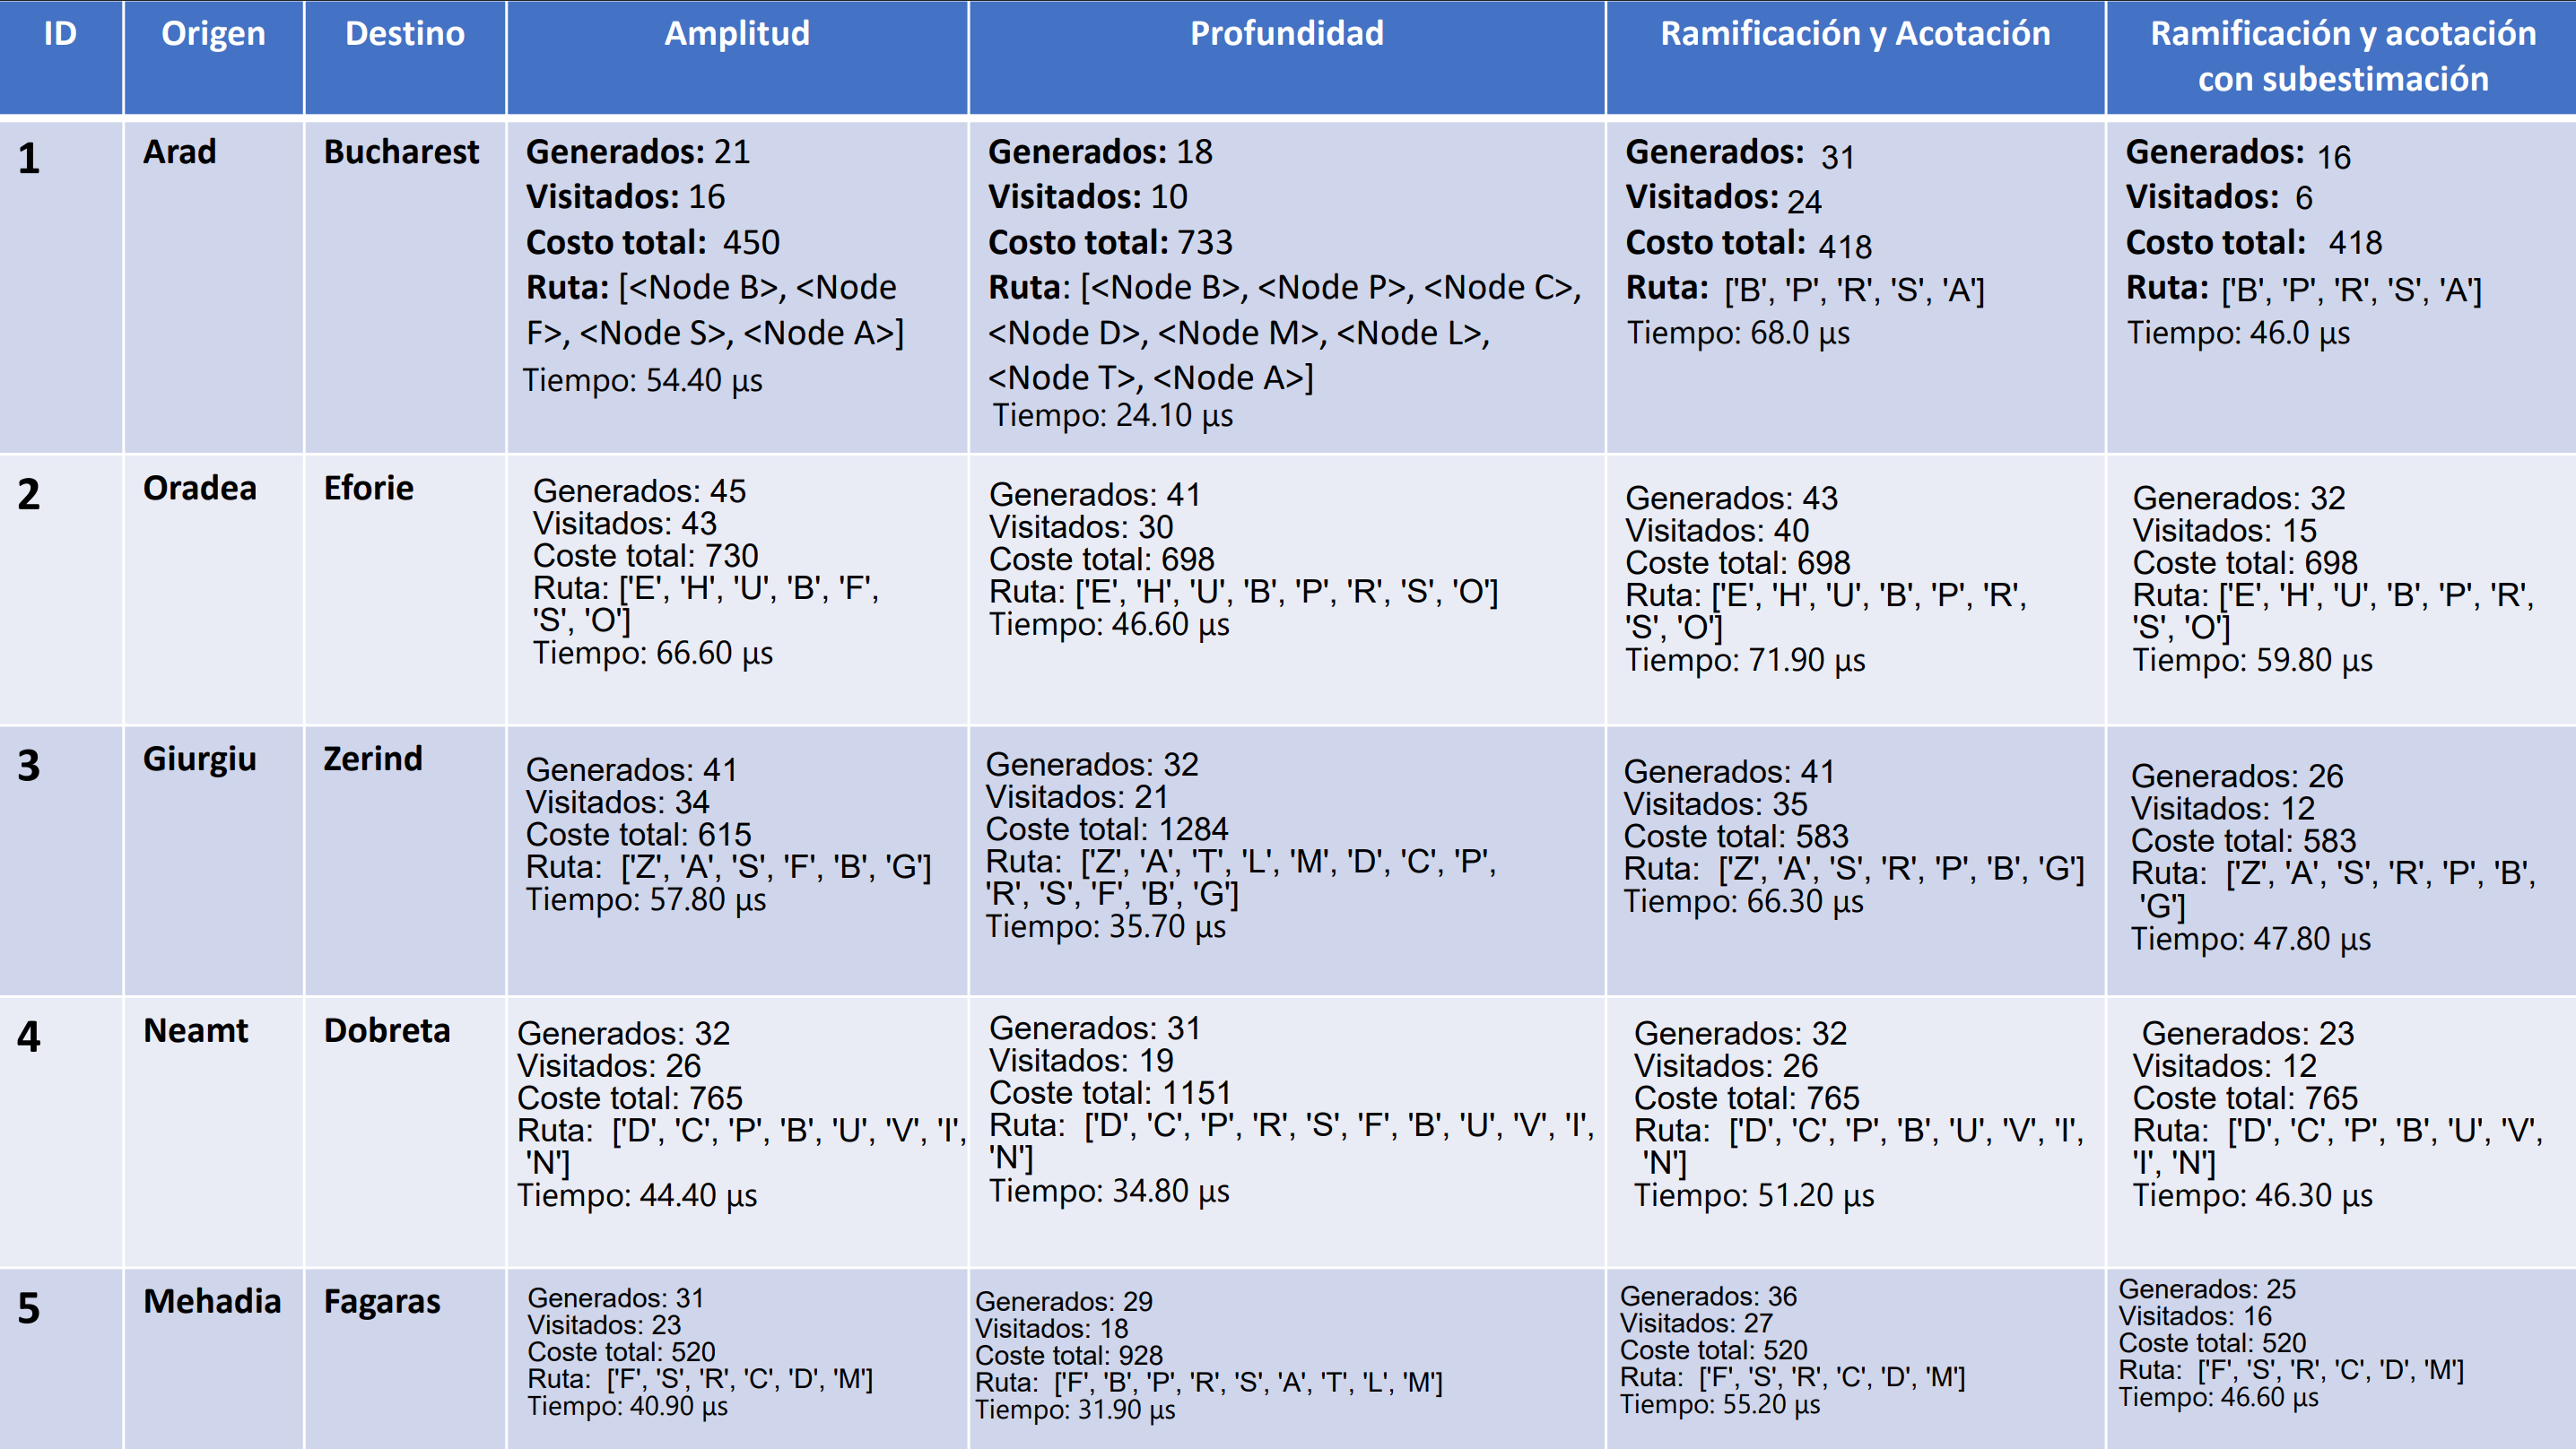

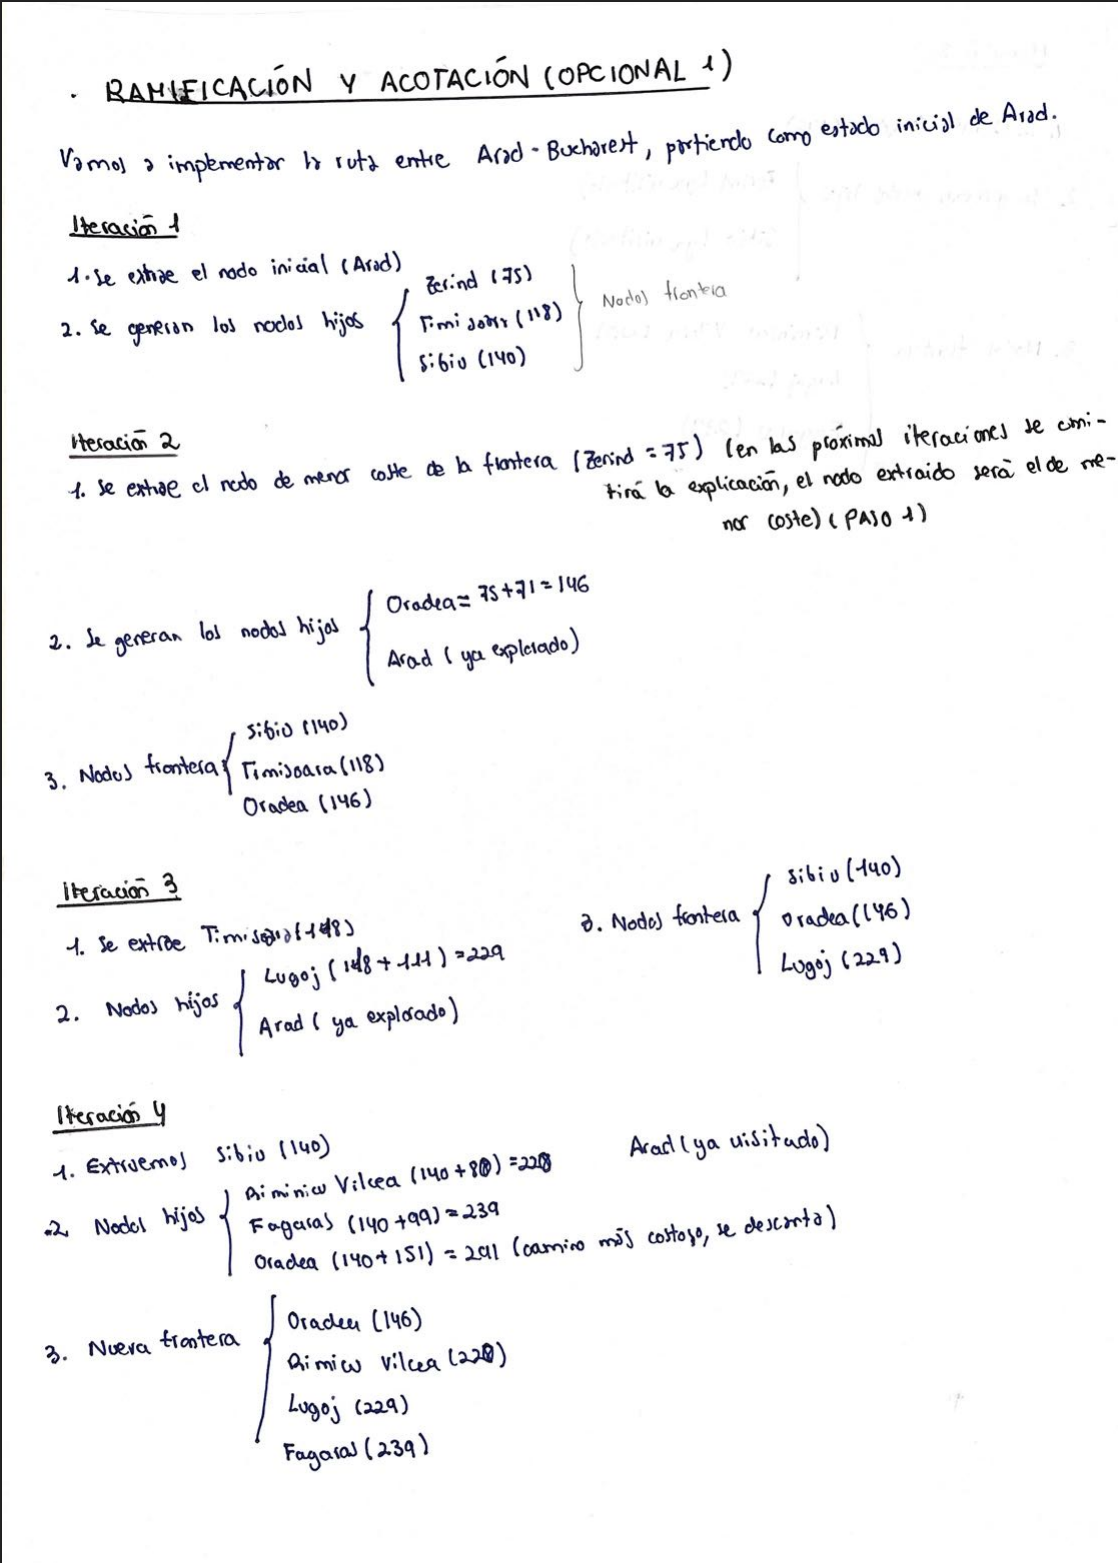

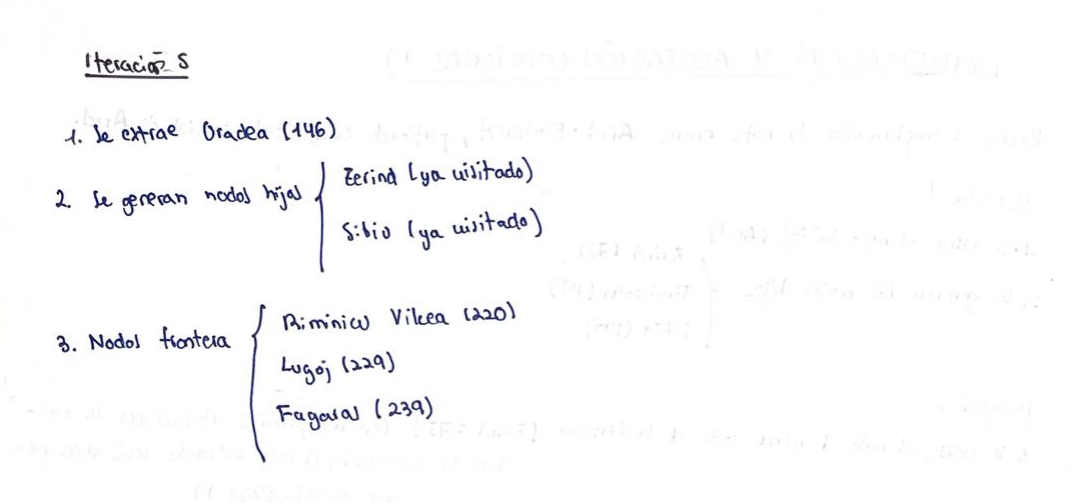